In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
import math
from sklearn.metrics import mean_squared_error

# Funções Auxiliares

In [3]:
def normalize(df):
    mindf = df.min()
    maxdf = df.max()
    return (df-mindf)/(maxdf-mindf)

In [4]:
def denormalize(norm, _min, _max):
    return [(n * (_max-_min)) + _min for n in norm]

In [5]:
def split_data(df, interval):
    sample_df = df.loc[interval]

    week = (sample_df.index.day - 1) // 7 + 1

    # PARA OS TESTES:
    # 2 SEMANAS PARA TREINAMENTO
    train_df = sample_df.loc[week <= 2]

    # 1 SEMANA PARA VALIDACAO
    validation_df = sample_df.loc[week == 3]

    # 1 SEMANA PARA TESTES
    test_df = sample_df.loc[week > 3]
    
    return (train_df, validation_df, test_df)

In [6]:
def calculate_rmse(test, forecast, order, step):
    rmse = math.sqrt(mean_squared_error(test.iloc[(order):], forecast[:-step]))
    print("RMSE : "+str(rmse))
    return rmse

In [7]:
def reconstruct_ssa_series(clean, residual):
    return [r + c for r, c in zip(residual,clean)]

In [8]:
def save_obj(obj, name ):
    with open('results/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('results/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [9]:
def difference(raw_df, interval=1):
    df_diff = pd.DataFrame(columns=raw_df.columns, index=raw_df.index[1:])
    
    for col in raw_df.columns:
        raw_array = raw_df[col]
        diff = []
        for i in range(interval, len(raw_array)):
            value = raw_array[i] - raw_array[i - interval]
            diff.append(value)
        
        df_diff[col] = diff
    return df_diff

In [10]:
def inverse_difference(raw_series, diff_series):
    inverted = []
    for i in range(len(diff_series)):
        interval = len(raw_series)-i
        value = diff_series[i] + raw_series[-interval]
        inverted.append(value)
        
    return inverted

# Load Dataset
Split the data into train, validation and test subsets

In [11]:
#Set target and input variables 
target_station = 'WTG01'

#All neighbor stations with residual correlation greater than .90
neighbor_stations_90 = ['WTG01','WTG02','WTG03','WTG05','WTG06']

In [12]:
df = pd.read_pickle("df_wind_speed.pkl")

In [13]:
#Normalize Data

# Save Min-Max for Denorm
min_raw = df[target_station].min()

max_raw = df[target_station].max()

# Perform Normalization
norm_df = normalize(df)

In [14]:
# Split data
interval = ((df.index >= '2017-05') & (df.index <= '2018-05'))
#interval = ((df.index >= '2010-11') & (df.index <= '2010-12'))

(train_df, validation_df, test_df) = split_data(df, interval)
(norm_train_df, norm_validation_df, norm_test_df) = split_data(norm_df, interval)

## Forecasting with Raw Time Series

For each dataset, all the time series were normalized

## Persistence

In [16]:
def persistence_forecast(train, test, step):
    predictions = []
    
    for t in np.arange(0,len(test), step):
        yhat = [test.iloc[t]]  * step
        predictions.extend(yhat)
        
    return predictions

In [17]:
step = 1
persistence_order = 1

forecast = persistence_forecast(norm_train_df[target_station], norm_test_df[target_station],step)
forecast = denormalize(forecast, min_raw, max_raw)

rmse = calculate_rmse(test_df[target_station], forecast, persistence_order, step)

RMSE : 0.6324497271451676


In [23]:
result = {'rmse': rmse, 'final': forecast}
save_obj(result, name="wind_raw_persistence_1")

## SARIMA

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

/Users/cseveriano/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [50]:
def sarima_forecast(train, test, arima_order, sarima_order, step):

    predictions = []
    window_size = sarima_order[3] * 5
    
    for date in train.index.to_period('M').unique():
        
        #history = list(train[str(date)].iloc[-window_size:])
        history = list(train[str(date)])
        window_size = len(history)
        
        model = SARIMAX(history, order=arima_order, seasonal_order=sarima_order,enforce_invertibility=False,enforce_stationarity=False)
        model_fit = model.fit(disp=True,enforce_invertibility=False,  method='powell', maxiter=200)
        
        #save the state parameter
        est_params = model_fit.params
        est_state = model_fit.predicted_state[:, -1]
        est_state_cov = model_fit.predicted_state_cov[:, :, -1]

        print("Predicting : "+str(date))
        
        st = 0
        test_date = test[str(date)]
        
        for t in np.arange(1,len(test_date)+1,step):
            obs = test_date.iloc[st:t].values
            history.extend(obs)
            history = history[-window_size:]
            
            mod_updated = SARIMAX(history, order=arima_order, seasonal_order=sarima_order,enforce_invertibility=False,enforce_stationarity=False)
            mod_updated.initialize_known(est_state, est_state_cov)
            mod_frcst = mod_updated.smooth(est_params)

        
            yhat = mod_frcst.forecast(step)   
            predictions.extend(yhat)
            
            est_params = mod_frcst.params
            est_state = mod_frcst.predicted_state[:, -1]
            est_state_cov = mod_frcst.predicted_state_cov[:, :, -1]
            
            st = t
                
    return predictions

In [51]:
order = 1
step = 1
arima_order = (2, 1, 2)
sarima_order = (1, 1, 1, 61)
forecast = sarima_forecast(norm_train_df[target_station], norm_test_df[target_station], arima_order, sarima_order, step)
forecast = denormalize(forecast, min_raw, max_raw)
rmse = calculate_rmse(test_df[target_station], forecast, order, step)

Optimization terminated successfully.
         Current function value: -1.864060
         Iterations: 6
         Function evaluations: 560
Predicting : 2017-05


KeyboardInterrupt: 

In [46]:
result = {'rmse': rmse, 'final': forecast}

In [47]:
save_obj(result, name="wind_raw_sarima_1")

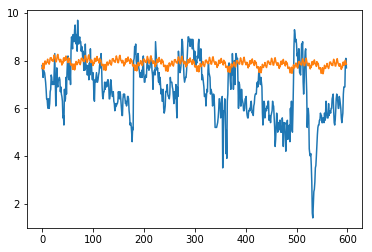

In [49]:
plt.plot(test_df[target_station].iloc[1:600].values)
plt.plot(forecast[:599])
plt.show()


In [44]:
def sarima_forecast(train, test, arima_order, sarima_order, step):

    predictions = []
    
    for date in train.index.to_period('M').unique():
        print("Predicting : "+str(date))
        history = list(train[str(date)])
        test_steps = len(test[str(date)])
        print("Number of steps : "+str(test_steps))
        
        model = SARIMAX(history, order=arima_order, seasonal_order=sarima_order,enforce_invertibility=False,enforce_stationarity=False)
        model_fit = model.fit(disp=True,enforce_invertibility=False, method='powell', maxiter=200)
        yhat = model_fit.forecast(test_steps)      
        
        predictions.extend(yhat)
    
    return predictions

In [45]:
order = 1
step = 1
arima_order = (2, 1, 2)
sarima_order = (1, 1, 1, 61)
forecast = sarima_forecast(norm_train_df[target_station], norm_test_df[target_station], arima_order, sarima_order, step)
forecast = denormalize(forecast, min_raw, max_raw)
rmse = calculate_rmse(test_df[target_station], forecast, order, step)

Predicting : 2017-05
Number of steps : 1038
Optimization terminated successfully.
         Current function value: -1.864060
         Iterations: 6
         Function evaluations: 560
Predicting : 2017-06
Number of steps : 1112
Optimization terminated successfully.
         Current function value: -1.727047
         Iterations: 3
         Function evaluations: 269
Predicting : 2017-07
Number of steps : 1439
Optimization terminated successfully.
         Current function value: -1.571208
         Iterations: 5
         Function evaluations: 437
Predicting : 2017-08
Number of steps : 1439
Optimization terminated successfully.
         Current function value: -1.871653
         Iterations: 4
         Function evaluations: 342
Predicting : 2017-09
Number of steps : 1294
Optimization terminated successfully.
         Current function value: -1.603497
         Iterations: 4
         Function evaluations: 340
Predicting : 2017-10
Number of steps : 1393
Optimization terminated successfully.
   

In [43]:
forecast[:99]

[7.8545310690312569,
 8.4913644723100763,
 7.66412066383098,
 7.4837396092870145,
 7.4180714854582366,
 7.8631097612963892,
 7.6870701841919473,
 6.5861730542909145,
 6.9690888625238534,
 6.748388701857686,
 6.8495970626665548,
 6.7452398165321892,
 6.160509241861309,
 5.3378349348023244,
 6.0119723427420446,
 5.9195508599539117,
 5.803513972026046,
 6.6282835003170026,
 7.0382842379857768,
 7.5103172987335958,
 7.4627918006024316,
 6.9872725874885386,
 6.8384112303544295,
 7.8402419947085153,
 6.9246446674878168,
 7.5008804306754016,
 7.9093390319150743,
 7.1451425532009383,
 6.501197889414339,
 7.3138498093323125,
 7.323482737105957,
 7.2699444172344272,
 7.1051650986365544,
 6.5775873765621666,
 7.0189687516986892,
 7.3598479725683665,
 7.1414598531691516,
 6.9789413046602693,
 7.0379389588813757,
 6.4027444578563113,
 6.6120929215267275,
 6.7314895601986757,
 4.9814247384505519,
 5.5761955550318474,
 5.9299354976166851,
 6.1179657329577282,
 6.0649456635828605,
 5.7711750083561366,

## Vector Autoregressive - VAR

In [18]:
from statsmodels.tsa.api import VAR, DynamicVAR

C:\Users\cseve\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [19]:
def var_forecast(train, test, target, order, step):
    model = VAR(train.values)
    results = model.fit(maxlags=order)
    lag_order = results.k_ar
    print("Lag order:" + str(lag_order))
    forecast = []

    for i in np.arange(0,len(test)-lag_order+1,step) :
        forecast.extend(results.forecast(test.values[i:i+lag_order],step))

    forecast_df = pd.DataFrame(columns=test.columns, data=forecast)
    return forecast_df[target].values

In [20]:
var_order = 4
step = 1

forecast = var_forecast(norm_train_df[neighbor_stations_90], norm_test_df[neighbor_stations_90], target_station, var_order, step)
forecast = denormalize(forecast, min_raw, max_raw)

C:\Users\cseve\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


Lag order:4


In [21]:
rmse = calculate_rmse(test_df[target_station], forecast, var_order, step)

RMSE : 0.5926842747779723


In [26]:
result = {'rmse': rmse, 'final': forecast}
save_obj(result, name="wind_raw_var_1")

## Long Short Term Memory - LSTM

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## Multivariate LSTM

In [27]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [28]:
def lstm_multi_forecast(train_df, test_df, _order, _steps, _neurons, _epochs):

    
    nfeat = len(train_df.columns)
    nlags = _order
    nsteps = _steps
    nobs = nlags * nfeat
    
    train_reshaped_df = series_to_supervised(train_df, n_in=nlags, n_out=nsteps)
    train_X, train_Y = train_reshaped_df.iloc[:,:nobs].values, train_reshaped_df.iloc[:,-nfeat].values
    train_X = train_X.reshape((train_X.shape[0], nlags, nfeat))
    
    test_reshaped_df = series_to_supervised(test_df, n_in=nlags, n_out=nsteps)
    test_X, test_Y = test_reshaped_df.iloc[:,:nobs].values, test_reshaped_df.iloc[:,-nfeat].values
    test_X = test_X.reshape((test_X.shape[0], nlags, nfeat))
    
    # design network
    model = Sequential()
    model.add(LSTM(_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # fit network
    model.fit(train_X, train_Y, epochs=_epochs, batch_size=72, verbose=False, shuffle=False)
    
    forecast = model.predict(test_X)
        
    return forecast

In [29]:
neurons = 50
lstm_order = 2
epochs = 100
steps = 1

forecast = lstm_multi_forecast(norm_train_df[neighbor_stations_90], norm_test_df[neighbor_stations_90], lstm_order, steps, neurons, epochs)
forecast = denormalize(forecast, min_raw, max_raw)

In [30]:
forecast.append(0) ## para manter o mesmo tamanho dos demais

In [31]:
rmse = calculate_rmse(test_df[target_station], forecast, lstm_order, step)

RMSE : 0.6401103021592297


In [46]:
result = {'rmse': rmse, 'final': forecast}
save_obj(result, name="wind_raw_lstm_multi_1")

## Univariate LSTM

In [32]:
neurons = 50
lstm_order = 2
epochs = 100
steps = 1

forecast = lstm_multi_forecast(norm_train_df[[target_station]], norm_test_df[[target_station]], lstm_order, steps, neurons, epochs)
forecast = denormalize(forecast, min_raw, max_raw)

In [33]:
forecast.append(0) ## para manter o mesmo tamanho dos demais

In [34]:
rmse = calculate_rmse(test_df[target_station], forecast, lstm_order, step)
result = {'rmse': rmse, 'final': forecast}
save_obj(result, name="wind_raw_lstm_uni_1")

RMSE : 0.6539938570187164


## Multi Layer Perceptron - MLP

In [35]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [36]:
def mlp_forecast(train_df, test_df, _order, _steps, _neurons, _epochs):

    
    nfeat = len(train_df.columns)
    nlags = _order
    nsteps = _steps
    nobs = nlags * nfeat
    
    train_reshaped_df = series_to_supervised(train_df, n_in=nlags, n_out=nsteps)
    train_X, train_Y = train_reshaped_df.iloc[:,:nobs].values, train_reshaped_df.iloc[:,-nfeat].values
    
    test_reshaped_df = series_to_supervised(test_df, n_in=nlags, n_out=nsteps)
    test_X, test_Y = test_reshaped_df.iloc[:,:nobs].values, test_reshaped_df.iloc[:,-nfeat].values
    
    # design network
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=train_X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # fit network
    history = model.fit(train_X, train_Y, epochs=_epochs, batch_size=72, verbose=False, shuffle=False)   

    forecast = model.predict(test_X)
        
    return forecast

In [37]:
neurons = 50
mlp_order = 2
epochs = 500
steps = 1

forecast = mlp_forecast(norm_train_df[neighbor_stations_90], norm_test_df[neighbor_stations_90], mlp_order, steps, neurons, epochs)
forecast = denormalize(forecast, min_raw, max_raw)

In [38]:
forecast.append(0) ## para manter o mesmo tamanho dos demais

In [39]:
rmse = calculate_rmse(test_df[target_station], forecast, mlp_order, steps)

RMSE : 0.6597416765770521


In [40]:
result = {'rmse': rmse, 'final': forecast}
save_obj(result, name="wind_raw_mlp_multi_1")

## Univariate MLP

In [41]:
neurons = 50
mlp_order = 4
epochs = 500
steps = 1

forecast = mlp_forecast(norm_train_df[[target_station]], norm_test_df[[target_station]], mlp_order, steps, neurons, epochs)
forecast = denormalize(forecast, min_raw, max_raw)

forecast.append(0) ## para manter o mesmo tamanho dos demais

rmse = calculate_rmse(test_df[target_station], forecast, mlp_order, steps)

RMSE : 0.6395343954722552


In [42]:
result = {'rmse': rmse, 'final': forecast}
save_obj(result, name="wind_raw_mlp_uni_1")

## High Order FTS

In [15]:
from pyFTS.partitioners import Grid, Entropy, Util as pUtil
from pyFTS.models import hofts
from pyFTS.common import Transformations

In [17]:
def hofts_forecast(train_df, test_df, _order, _partitioner, _npartitions):
    
    fuzzy_sets = _partitioner(data=train_df.values, npart=_npartitions)
    model_simple_hofts = hofts.HighOrderFTS()
    

    model_simple_hofts.fit(train_df.values, order=_order, partitioner=fuzzy_sets)

    
    forecast = model_simple_hofts.predict(test_df.values)

    return forecast

In [20]:
hofts_order = 3
#partitioner = Entropy.EntropyPartitioner
partitioner = Grid.GridPartitioner
nparts = 80


forecast = hofts_forecast(norm_train_df[target_station], norm_test_df[target_station], hofts_order, partitioner, nparts)
forecast = denormalize(forecast, min_raw, max_raw)

In [21]:
step = 1
rmse = calculate_rmse(test_df[target_station], forecast, hofts_order, step)

RMSE : 0.6389693371408669


In [60]:
result = {'rmse': rmse, 'final': forecast}
save_obj(result, name="wind_raw_hofts_1")

## Clustered Multivariate

In [22]:
from models import KMeansPartitioner
from models import sthofts

In [23]:
import importlib
importlib.reload(sthofts)

<module 'models.sthofts' from '/Users/cseveriano/Google Drive/Doutorado/Codes/spatio-temporal-forecasting/src/models/sthofts.py'>

In [24]:
def sthofts_forecast(train_df, test_df, target, _order, npartitions):
    
    _partitioner = KMeansPartitioner.KMeansPartitioner(data=train_df.values, npart=npartitions, batch_size=1000, init_size=npartitions*3)
    model_sthofts = sthofts.SpatioTemporalHighOrderFTS()
    
    model_sthofts.fit(train_df.values, num_batches=100, order=_order, partitioner=_partitioner)
    forecast = model_sthofts.predict(test_df.values)
    forecast_df = pd.DataFrame(data=forecast, columns=test_df.columns)
    return forecast_df[target].values

In [25]:
sthofts_order = 4
nparts = 20


forecast = sthofts_forecast(norm_train_df[neighbor_stations_90], norm_test_df[neighbor_stations_90], target_station, sthofts_order, nparts)
forecast = denormalize(forecast, min_raw, max_raw)

In [26]:
step = 1
rmse = calculate_rmse(test_df[target_station], forecast, sthofts_order, step)

RMSE : 0.8585187497096866


In [27]:
result = {'rmse': rmse, 'final': forecast}
save_obj(result, name="wind_raw_sthofts_1")

## Conditional Variance FTS - CVFTS

In [28]:
from pyFTS.models.nonstationary import cvfts
from pyFTS.models.nonstationary import partitioners as nspartitioners

In [29]:
def cvfts_forecast(train, test, _partitioner,_partitions):
    
    fuzzy_sets =  nspartitioners.PolynomialNonStationaryPartitioner(data=train.values, part=_partitioner(data=train.values, npart=_partitions), degree=2)
                    
    model_cvfts = cvfts.ConditionalVarianceFTS()
    model_cvfts.fit(train.values, parameters=1, partitioner=fuzzy_sets)

    forecast = model_cvfts.predict(test.values)

    return forecast

In [35]:
partitioner = Grid.GridPartitioner
nparts = 90


forecast = cvfts_forecast(norm_train_df[target_station], norm_test_df[target_station], partitioner, nparts)
forecast = denormalize(forecast, min_raw, max_raw)

In [36]:
step = 1
rmse = calculate_rmse(test_df[target_station], forecast, 1, step)
result = {'rmse': rmse, 'final': forecast}
save_obj(result, name="wind_raw_cvfts_1")

RMSE : 0.669826676077098
